In [1]:
################# FIRST DEMO FOR A 2D RETROSPECTIVE CS RECONSTRUCTION VIA DICTIONARY LEARNING ##################
################################ ON THE CAMCAN DATABASE, T1 WEIGHTING @ 3T #####################################

In [2]:
################################################ IMPORTS #######################################################

# basic imports
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.fftpack as pfft
import numpy as np
import scipy.io

#pisap imports
import pisap
print pisap.__version__

from pisap.numerics.gradient import Grad2DAnalysis, Grad2DSynthesis
from pisap.numerics.linear import Wavelet, DictionaryLearningWavelet
from pisap.numerics.fourier import NFFT, FFT
from pisap.numerics.cost import ssim, snr, psnr, nrmse
from pisap.base.utils import subsampling_op
from pisap.base.utils import convert_mask_to_locations, crop_sampling_scheme
from pisap.numerics.reconstruct import sparse_rec_condat_vu
import data_provider

from pisap.tools_for_DL.images import CamcanImages
from pisap.tools_for_DL.dictionary import Dictionary

0.0.0


In [3]:
############################################# CAMCAN IMAGES ####################################################

# parameters of the Camcan database images
camcanimgs_path_begin="CamCan_database_10subjects/"
patch_size=(7,7)
size_ratio_sets=(0.6,0.4)
num_slice=100

# initializing the Camcan images,(camcanimgs = instance of the CamcanImages class)
camcanimgs=CamcanImages(camcanimgs_path_begin, patch_size, size_ratio_sets, num_slice)

# preprocessing camcanimgs
camcanimgs.preprocessing()

{'imgs_flat': [], 'imgs_patches_flat': [], 'training_set': [], 'h': 156, 'num_slice': 100, 'size_testing': 4, 'patch_shape': (7, 7), 'nb_imgs': 10, 'testing_set_ref': [], 'img_shape': (189, 156), 'masks': [], 'w': 189, 'imgs': [], 'data_path_begin': 'CamCan_database_10subjects/', 'size_training': 6, 'size_ratio_sets': (0.6, 0.4)}
preprocessing starting...
1/10
10/10
preprocessing ended!


{'data_path_begin': 'CamCan_database_10subjects/',
 'h': 156,
 'img_shape': (189, 156),
 'imgs': [array([[  1.06181158e-02,   6.03192113e-03,   1.20259719e-02, ...,
            7.54373102e-03,   1.07019795e-02,   8.54861084e-03],
         [  2.25360948e-03,   4.66160383e-03,   9.70158726e-03, ...,
            8.51742923e-03,   8.97653773e-03,   9.35979374e-03],
         [  6.78997673e-03,   6.27524406e-03,   7.01430766e-03, ...,
            7.87807442e-03,   6.02501398e-03,   9.29331873e-03],
         ..., 
         [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
            7.20545242e-04,   9.89634893e-04,   6.61704747e-04],
         [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
            1.37681130e-03,   3.41172446e-04,   7.45469151e-06],
         [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
            1.35063881e-03,   1.08869013e-03,   3.96351039e-04]], dtype=float32),
  array([[ 0.01807778,  0.01889796,  0.01880037, ...,  0.00427081,
 

{'n_iter': 500, 'atoms': array([ 0.]), 'dico': [], 'n_components': 25, 'alpha': 1}
learning_atoms starting...
10/36
20/36
30/36
learning_atoms ended!


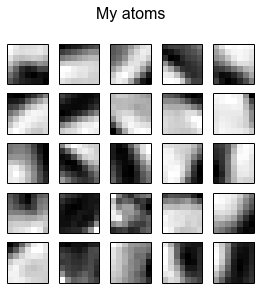

'My atoms'

In [4]:
############################################# DICTIONARY #######################################################

# dictonary parameters
n_components=25
alpha=1
n_iter=500

# initializing the dictionary, (dictionary = instance of the Dictionary class)
dictionary=Dictionary(n_components, alpha, n_iter)

# learning the dictionary atoms
dictionary.learning_atoms(camcanimgs)

# saving the dictionary atoms
# dictionary.saving_atoms('essai.npy')

# plotting the dictionary atoms
dictionary.plotting(camcanimgs, 'My atoms')

<matplotlib.colorbar.Colorbar instance at 0x7f60e7414ef0>

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


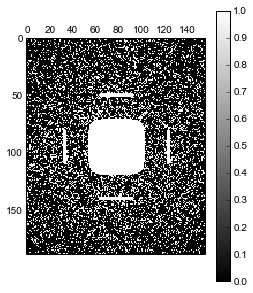

In [5]:
########################################### SAMPLING SCHEME ####################################################

# path of the sampling scheme to perform retrospective Compressed Sensing
sampling_scheme_path='sampling_schemes/scheme_256_R5_power1_fullCenter.mat'

# getting and plotting the sampling scheme
sampling_scheme=camcanimgs.get_sampling_scheme(sampling_scheme_path)

plt.figure()
plt.matshow(sampling_scheme, cmap='gray')
plt.colorbar()

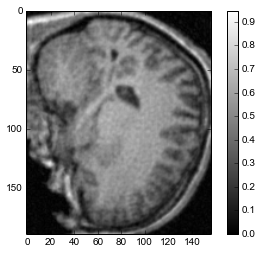

In [6]:
################################### RETROSPECTIVE COMPRESSED SENSING ###########################################

# undersampling an image of the testing set in the Fourier domain with the sampling scheme
all_retrospective_undersampled_kspaces=camcanimgs.retrospectiveCS(sampling_scheme_path)
IMGTEST_kspaceCS_datavalues=all_retrospective_undersampled_kspaces[0]

# zero order solution
plt.figure()
plt.imshow(np.abs(pfft.ifft2(IMGTEST_kspaceCS_datavalues)), cmap='gray')
plt.colorbar()
plt.show()

In [7]:
############################################# METRICS ##########################################################

IMGTEST_ref=camcanimgs.testing_set_ref[0]

metrics = {#'ssim':{'metric':ssim,
            #      'mapping': {'x_new': 'test', 'y_new':None},
             #     'cst_kwargs':{'ref':IMGTEST_ref},
              #    'early_stopping': True,
               #    },
           'snr':{'metric':snr,
                  'mapping': {'x_new': 'test', 'y_new':None},
                  'cst_kwargs':{'ref':IMGTEST_ref},
                  'early_stopping': True,
                   },
           'psnr':{'metric':psnr,
                  'mapping': {'x_new': 'test', 'y_new':None},
                  'cst_kwargs':{'ref':IMGTEST_ref},
                  'early_stopping': True,
                   }, 
           'nrmse':{'metric':nrmse,
                  'mapping': {'x_new': 'test', 'y_new':None},
                  'cst_kwargs':{'ref':IMGTEST_ref},
                  'early_stopping': True,
                   },           
          }

In [8]:
####################################### RECONSTRUCTION PARAMETERS ##############################################

samples = convert_mask_to_locations(pfft.fftshift(sampling_scheme))

gradient_param = {"ft_cls": {FFT: {"samples_locations": samples, "img_shape": camcanimgs.img_shape}}}

pisap_parameters = {
    'data':pfft.ifftshift(IMGTEST_kspaceCS_datavalues),
    'gradient_cls':Grad2DAnalysis,
    'gradient_kwargs':gradient_param,
    'linear_cls':DictionaryLearningWavelet,
    'linear_kwargs':{"dictionary": dictionary.dico, "atoms": dictionary.dico.components_,
                     "type_decomposition": 'prodscalar', "img_shape": camcanimgs.img_shape},
    'max_nb_of_iter':100,
    'mu':9e-6,
    'metrics':metrics,
    'verbose':1,
    }

In [9]:
################################### CS RECONSTRUCTION WITH CONDA-VU ############################################
########################################### FOR ONE IMAGE ######################################################

x, y, saved_metric = sparse_rec_condat_vu(**pisap_parameters)


# RQ: You should obtain:
# - mu:  9e-06
# - lipschitz_cst:  1.1
# - tau:  2.57341408943e-06
# - sigma:  0.5
# - rho:  1.0
# - std:  None
# - 1/tau - sigma||L||^2 >= beta/2:  True
# --------------------
# 25% (25 of 100) |######                  | Elapsed Time: 0:13:46 ETA:  0:38:19
# -------> early-stopping done

Starting Condat-Vu primal-dual algorithm.


/home/hc253658/STAGE/src/pisap/pisap/base/utils.py:71: RuntimeWarning: invalid value encountered in divide
  patches /= np.std(patches, axis=0)
/usr/lib/python2.7/dist-packages/sklearn/decomposition/dict_learning.py:152: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_Xy=copy_cov).T


 - mu:  9e-06
 - lipschitz_cst:  1.1
 - tau:  2.57341408943e-06
 - sigma:  0.5
 - rho:  1.0
 - std:  None
 - 1/tau - sigma||L||^2 >= beta/2:  True
--------------------


 25% (25 of 100) |######                  | Elapsed Time: 0:13:46 ETA:  0:38:19

-------> early-stopping done


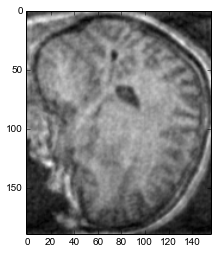

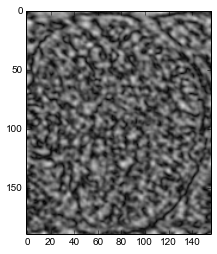

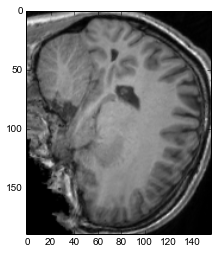

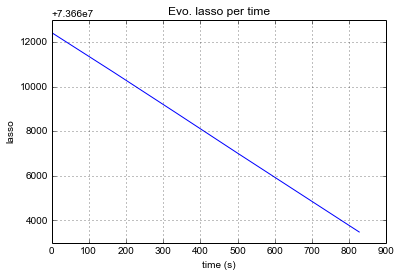

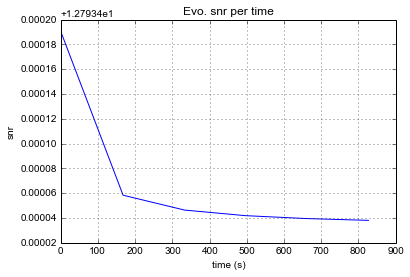

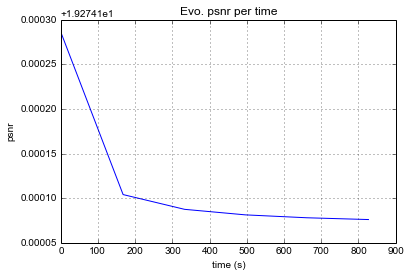

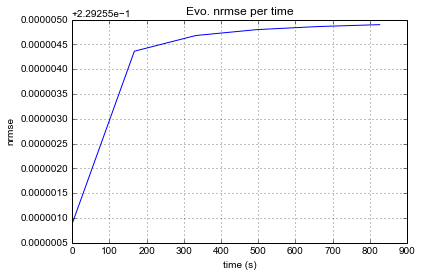

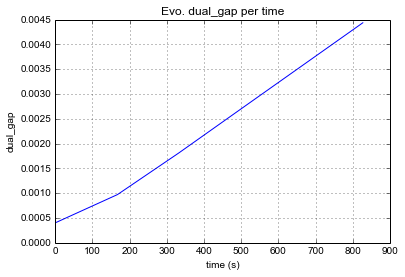

In [10]:
################################### PLOTTING RECONSTRUCTION AND METRICS ########################################

# solution in the image domain
plt.figure()
plt.imshow(np.abs((x.data)), cmap='gray')

# solution in the dual
plt.figure()
plt.imshow(np.abs(y.adj_op(y.coeff)),cmap='gray')

# full Cartesian reference
plt.figure()
plt.imshow(np.abs(IMGTEST_ref),cmap='gray')

# metric curves
for name, metric in saved_metric.iteritems():
    fig = plt.figure()
    plt.grid()
    plt.plot(metric['time'], metric['values'])
    plt.xlabel("time (s)")
    plt.ylabel(name)
    plt.title("Evo. {} per time".format(name))

plt.show()

In [ ]:
## Comments

# it was faster using NFFT in 'gradient_kwargs' 'ft_cls' (about 5 to 6 minutes)

# not possible to compute the SSIM score (complex values)

# issues to be fixed:
# the solution in the dual is not good at all and the Evo. dual_gap per time keeps increasing